In [1]:
import pandas as pd
import os

Step 1: Data Summary Generation
To gain an initial understanding of the raw transaction data, we implemented a script to automatically generate detailed summaries for each downloaded CSV file.

Key Actions:
Iterated over all *_transactions.csv files in the download/ directory

For each file:

    Loaded the CSV using pandas

    Extracted:

        Total number of rows

        Column-wise data types

        Count of distinct values
            
        Top & bottom 10 frequent values

        Top & bottom 10 lexicographic values (where applicable)

Saved structured summaries as .txt files in the data_summary/ directory


This helped identify:

Redundant or low-cardinality columns

Columns with missing or inconsistent formats

Candidates for categorical encoding or cleaning

In [ ]:
DOWNLOAD_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\download"
SUMMARY_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\data_summary"
os.makedirs(SUMMARY_DIR, exist_ok=True)

def summarize_file(filepath, summary_path):
    summary_lines = []
    summary_lines.append(f"\n File: {filepath}")
    
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        summary_lines.append(f" Error reading file: {e}")
        with open(summary_path, "w", encoding="utf-8") as f:
            f.write("\n".join(summary_lines))
        return

    summary_lines.append(f" Total Rows: {len(df)}\n")
    
    for col in df.columns:
        summary_lines.append(f" Column: {col}")
        summary_lines.append(f"   ▪ Data Type: {df[col].dtype}")
        summary_lines.append(f"   ▪ Total Values: {df[col].shape[0]}")
        summary_lines.append(f"   ▪ Distinct Values: {df[col].nunique()}")

        # Top 10 frequent values
        summary_lines.append("\n    Top 10 values by count:")
        summary_lines.append(df[col].value_counts().head(10).to_string())

        # Bottom 10 frequent values
        summary_lines.append("\n    Bottom 10 values by count:")
        summary_lines.append(df[col].value_counts().tail(10).to_string())

        # Lexicographic order
        try:
            summary_lines.append("\n    Top 10 lexicographically:")
            summary_lines.append(
                df[col].dropna().astype(str).sort_values().head(10).value_counts().to_string()
            )

            summary_lines.append("\n    Bottom 10 lexicographically:")
            summary_lines.append(
                df[col].dropna().astype(str).sort_values(ascending=False).head(10).value_counts().to_string()
            )
        except Exception as e:
            summary_lines.append(f"    Lex sort error: {e}")
        summary_lines.append("\n" + "-"*60 + "\n")

    # Save to file
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write("\n".join(summary_lines))

    print(f" Summary saved for {os.path.basename(filepath)}")

# Loop through all downloaded CSVs
files = [
    os.path.join(DOWNLOAD_DIR, f)
    for f in os.listdir(DOWNLOAD_DIR)
    if f.endswith("transactions.csv")
]

for file in files:
    filename = os.path.basename(file).replace(".csv", "_summary.txt")
    summary_path = os.path.join(SUMMARY_DIR, filename)
    summarize_file(file, summary_path)

 Summary saved for transaction_data_2025-04-07_transactions.csv
 Summary saved for transaction_data_2025-04-08_transactions.csv
 Summary saved for transaction_data_2025-04-09_transactions.csv
 Summary saved for transaction_data_2025-04-10_transactions.csv
 Summary saved for transaction_data_2025-04-11_transactions.csv
 Summary saved for transaction_data_2025-04-12_transactions.csv
 Summary saved for transaction_data_2025-04-13_transactions.csv
 Summary saved for transaction_data_2025-04-14_transactions.csv
 Summary saved for transaction_data_2025-04-15_transactions.csv
 Summary saved for transaction_data_2025-04-16_transactions.csv
 Summary saved for transaction_data_2025-04-17_transactions.csv
 Summary saved for transaction_data_2025-04-18_transactions.csv
 Summary saved for transaction_data_2025-04-19_transactions.csv
 Summary saved for transaction_data_2025-04-20_transactions.csv
 Summary saved for transaction_data_2025-04-21_transactions.csv
 Summary saved for transaction_data_2025

Step 2: Data Cleaning & Feature Engineering
To prepare the raw transaction data for machine learning, we implemented a structured cleaning and feature engineering pipeline.

Key Actions:
    Efficient Data Loading

        Used predefined dtype mapping for memory optimization

        Parsed timestamp as datetime object

    Data Cleaning

        Dropped rows with missing critical fields (transaction_id, timestamp, amount)

        Standardized text fields (merchant_name, location_city, device_type)

        Removed duplicate transactions

        Detected outliers using the IQR method and flagged them

    Feature Engineering

        Extracted hour and day of week from timestamp

        Calculated recency (in seconds) per user

        Flagged anomalies based on:

            Outlier transactions

            Transactions occurring in under 10 seconds

    Output:

        Saved cleaned and enriched datasets to the cleaned_data/ directory as _cleaned.csv

In [2]:
import pandas as pd
import numpy as np
import os
import traceback

# === Directories ===
DOWNLOAD_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\download"
CLEAN_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data"
os.makedirs(CLEAN_DIR, exist_ok=True)

# === Column Data Types for Efficient Reading ===
dtype_map = {
    "transaction_id": str,
    "user_id": str,
    "merchant_id": str,
    "merchant_name": str,
    "merchant_category": str,
    "amount": float,
    "currency": str,
    "location_country": str,
    "location_city": str,
    "is_online": bool,
    "device_type": str,
    "status": str
}

# === Load CSV File ===
def load_transaction_file(filepath):
    print(f"Loading: {filepath}")
    try:
        df = pd.read_csv(filepath, dtype=dtype_map, parse_dates=["timestamp"], low_memory=False)
        return df
    except Exception as e:
        print(f"Failed to load {filepath}: {e}")
        return None

# === Clean the DataFrame ===
def clean_transaction_data(df):
    print("Cleaning data...")

    # Drop rows where critical fields are missing
    df = df.dropna(subset=["transaction_id", "timestamp", "amount"])

    # Clean selected text fields (trim and lowercase)
    for col in ["merchant_name", "location_city", "device_type"]:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna("Unknown")
            df[col] = df[col].str.strip()
            df[col] = df[col].str.lower()

    # Remove duplicate transactions
    df = df.drop_duplicates(subset=["transaction_id"])

    # Detect outliers using the IQR method
    q1 = df["amount"].quantile(0.25)
    q3 = df["amount"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df["is_outlier"] = (df["amount"] < lower) | (df["amount"] > upper)

    return df

# === Add Derived Features ===
def add_derived_features(df):
    print("Adding derived features...")

    # Convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Extract day of week and hour
    df["day_of_week"] = df["timestamp"].dt.day_name()
    df["hour"] = df["timestamp"].dt.hour

    # Calculate recency (time difference from previous transaction per user)
    df = df.sort_values(by=["user_id", "timestamp"])
    df["previous_time"] = df.groupby("user_id")["timestamp"].shift(1)
    df["recency_seconds"] = (df["timestamp"] - df["previous_time"]).dt.total_seconds()

    # Flag anomalies (either outliers or transactions occurring too quickly)
    df["anomaly_flag"] = df["is_outlier"] | (df["recency_seconds"] < 10)

    return df

# === Process All Files ===
files = [f for f in os.listdir(DOWNLOAD_DIR) if f.endswith(".csv") and "transactions" in f.lower()]
processed_count = 0

for file in files:
    try:
        full_path = os.path.join(DOWNLOAD_DIR, file)
        cleaned_file = os.path.join(CLEAN_DIR, file.replace(".csv", "_cleaned.csv"))

        # Skip processing if cleaned file already exists
        if os.path.exists(cleaned_file):
            print(f"Skipping (already cleaned): {file}")
            continue

        print(f"Processing: {file}")

        # Load, clean, and transform data
        df = load_transaction_file(full_path)
        if df is None:
            continue

        df = clean_transaction_data(df)
        df = add_derived_features(df)

        # Save cleaned file
        df.to_csv(cleaned_file, index=False)
        print(f"Cleaned file saved to: {cleaned_file}\n")

        processed_count += 1

    except MemoryError:
        print(f"MemoryError while processing {file}. Skipping...\n")
        continue
    except Exception as e:
        print(f"Error in file {file}: {e}")
        traceback.print_exc()
        continue

print(f"Finished processing {processed_count}/{len(files)} files.")


Processing: transaction_data_2025-04-07_transactions.csv
Loading: D:\Srijan\Project (bade wale)\Bicycle assignment\download\transaction_data_2025-04-07_transactions.csv
Cleaning data...
Adding derived features...
Cleaned file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data\transaction_data_2025-04-07_transactions_cleaned.csv

Processing: transaction_data_2025-04-08_transactions.csv
Loading: D:\Srijan\Project (bade wale)\Bicycle assignment\download\transaction_data_2025-04-08_transactions.csv
Cleaning data...
Adding derived features...
Cleaned file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data\transaction_data_2025-04-08_transactions_cleaned.csv

Processing: transaction_data_2025-04-09_transactions.csv
Loading: D:\Srijan\Project (bade wale)\Bicycle assignment\download\transaction_data_2025-04-09_transactions.csv
Cleaning data...
Adding derived features...
Cleaned file saved to: D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_dat

Step 3: Descriptive Analytics & Aggregation
    To extract business insights and summarize transaction patterns, we performed aggregations across key dimensions.

Key Actions:
    Data Sources

        Iterated through all cleaned CSV files in /cleaned_data/

    Aggregations Performed

        Daily Summary

            Total transactions and total amount aggregated by date

        Merchant Summary

            Count of transactions and cumulative amount per merchant

        Hourly Summary

            Volume and value of transactions grouped by hour of the day

Output Format (Stored in Python Dictionaries)

In [5]:
from collections import defaultdict

CLEAN_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data"

# Initialize aggregation containers
daily_stats = defaultdict(lambda: {"transaction_count": 0, "total_amount": 0})
merchant_count = defaultdict(int)
merchant_value = defaultdict(float)
hourly_stats = defaultdict(lambda: {"transaction_count": 0, "total_amount": 0})

# Process one file at a time
files = [os.path.join(CLEAN_DIR, f) for f in os.listdir(CLEAN_DIR) if f.endswith(".csv")]

for file in files:
    print(f"Processing: {os.path.basename(file)}")
    df = pd.read_csv(file, parse_dates=["timestamp"])

    # Ensure timestamp is valid
    df = df[df["timestamp"].notna()]

    # Add date column for grouping
    df["date"] = df["timestamp"].dt.date
    df["hour"] = df["timestamp"].dt.hour

    # Daily aggregation
    for d, group in df.groupby("date"):
        daily_stats[d]["transaction_count"] += group.shape[0]
        daily_stats[d]["total_amount"] += group["amount"].sum()

    # Merchant aggregation
    for m, group in df.groupby("merchant_name"):
        merchant_count[m] += group.shape[0]
        merchant_value[m] += group["amount"].sum()

    # Hourly aggregation
    for h, group in df.groupby("hour"):
        hourly_stats[h]["transaction_count"] += group.shape[0]
        hourly_stats[h]["total_amount"] += group["amount"].sum()


Processing: transaction_data_2025-04-07_transactions_cleaned.csv
Processing: transaction_data_2025-04-08_transactions_cleaned.csv
Processing: transaction_data_2025-04-09_transactions_cleaned.csv
Processing: transaction_data_2025-04-10_transactions_cleaned.csv
Processing: transaction_data_2025-04-11_transactions_cleaned.csv
Processing: transaction_data_2025-04-12_transactions_cleaned.csv
Processing: transaction_data_2025-04-13_transactions_cleaned.csv
Processing: transaction_data_2025-04-14_transactions_cleaned.csv
Processing: transaction_data_2025-04-15_transactions_cleaned.csv
Processing: transaction_data_2025-04-16_transactions_cleaned.csv
Processing: transaction_data_2025-04-17_transactions_cleaned.csv
Processing: transaction_data_2025-04-18_transactions_cleaned.csv
Processing: transaction_data_2025-04-19_transactions_cleaned.csv
Processing: transaction_data_2025-04-20_transactions_cleaned.csv
Processing: transaction_data_2025-04-21_transactions_cleaned.csv
Processing: transaction_d

Step 4: Structuring Aggregated Insights for Visualization
    After computing aggregated statistics, we transformed them into structured DataFrames for easy visualization and analysis.

Key Actions:
    Daily Summary Table (df_daily)

        Created a DataFrame with daily transaction counts and total transaction amounts.

        Useful for trend analysis over time.

    Top 10 Merchants by Count (df_merch_count)

        Identified merchants with the highest number of transactions.

        Helpful to assess merchant popularity and activity levels.

    Top 10 Merchants by Transaction Value (df_merch_value)

        Ranked merchants by total transaction volume (monetary).

        Useful for high-value partnerships or fraud risk monitoring.

    Hourly Summary Table (df_hourly)

        Aggregated transaction activity by each hour of the day.

        Useful to understand peak usage hours and optimize system readiness.

Output Ready for:
    Interactive or static visualizations (e.g., line charts, bar plots, heatmaps).

    Time-series modeling or business insights dashboards.

In [ ]:
# Daily
df_daily = pd.DataFrame([
    {"date": d, "transaction_count": v["transaction_count"], "total_amount": v["total_amount"]}
    for d, v in sorted(daily_stats.items())
])

# Top 10 merchants by count
df_merch_count = pd.DataFrame(merchant_count.items(), columns=["merchant_name", "transaction_count"])
df_merch_count = df_merch_count.sort_values("transaction_count", ascending=False).head(10)

# Top 10 merchants by value
df_merch_value = pd.DataFrame(merchant_value.items(), columns=["merchant_name", "total_value"])
df_merch_value = df_merch_value.sort_values("total_value", ascending=False).head(10)

# Hourly
df_hourly = pd.DataFrame([
    {"hour": h, "transaction_count": v["transaction_count"], "total_amount": v["total_amount"]}
    for h, v in sorted(hourly_stats.items())
])


Step 5: Exploratory Visualizations of Transaction Patterns
    We used Seaborn and Matplotlib to generate intuitive visualizations from the aggregated data.

    1. Daily Transaction Volume
        Chart: Line plot of transaction counts over time.

        Purpose: Highlights spikes, trends, and seasonality in user activity.

        Use Case: Useful for anomaly detection or capacity planning.

     2. Top 10 Merchants by Count
        Chart: Horizontal bar chart of merchants with the highest transaction frequencies.

        Purpose: Identifies key partners or merchants with high engagement.

        Use Case: Business partnerships, merchant monitoring, or prioritizing support.

    3. Hourly Transaction Pattern
        Chart: Line plot showing distribution of transactions across 24 hours.

        Purpose: Reveals peak usage hours and behavioral rhythms of users.

        Use Case: Optimizing server resources, scheduling promotional activities.

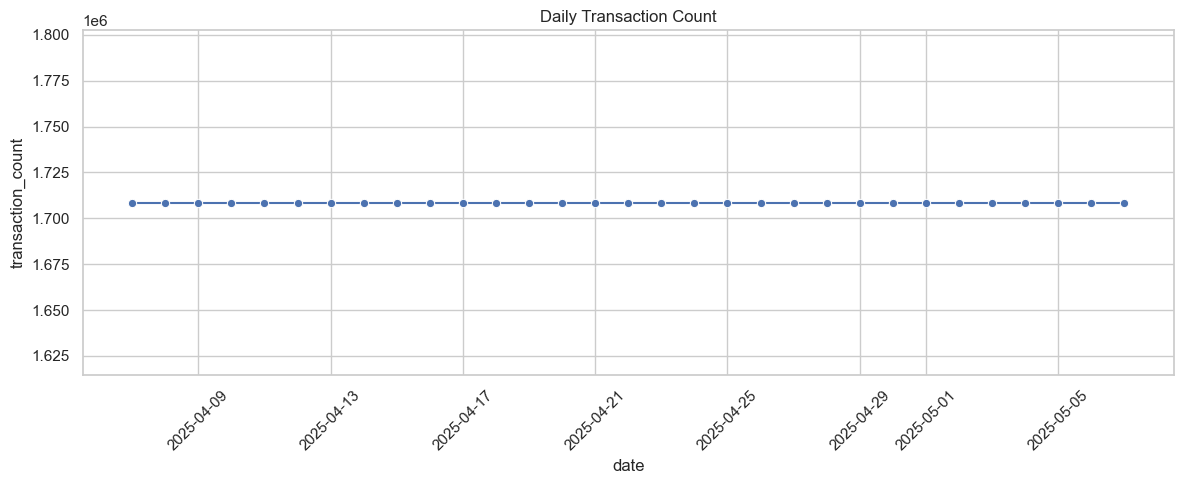

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19540\2813208495.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="transaction_count", y="merchant_name", data=df_merch_count, palette="Blues_d")


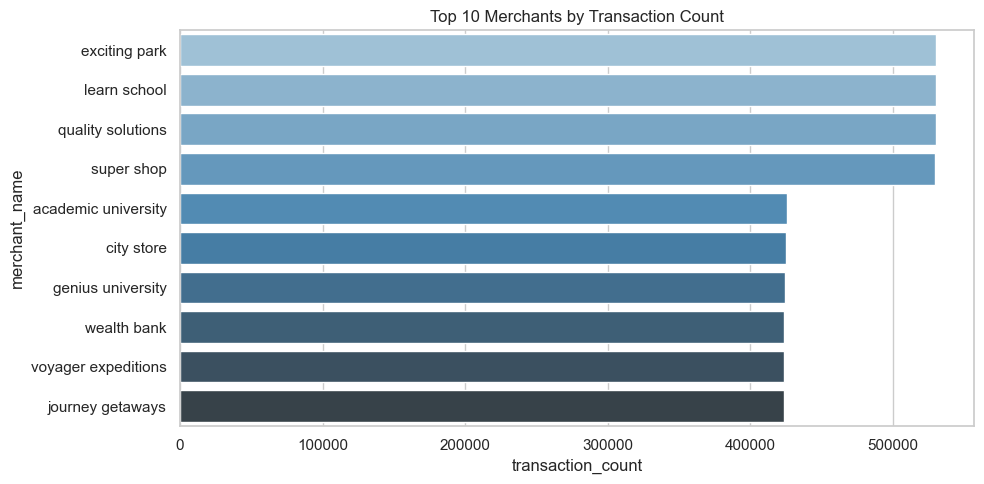

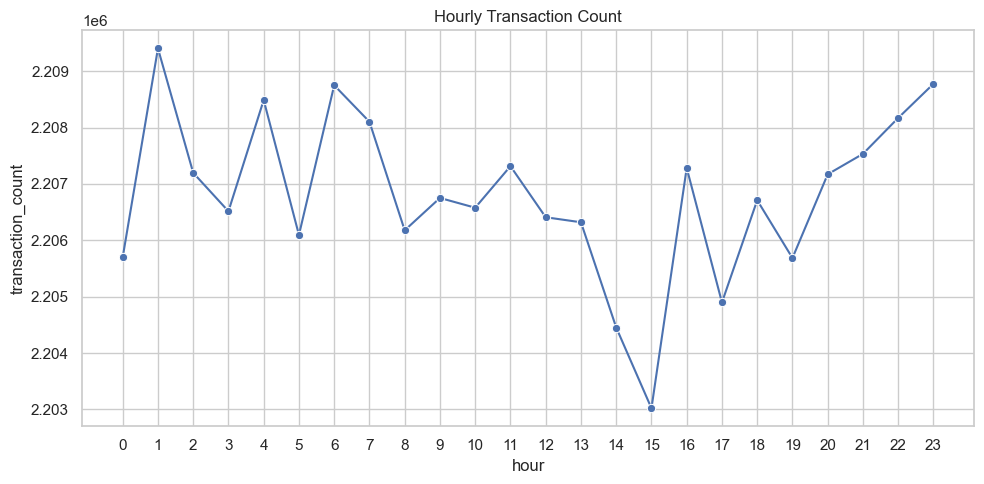

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Daily transaction count
plt.figure(figsize=(12, 5))
sns.lineplot(x="date", y="transaction_count", data=df_daily, marker="o")
plt.title("Daily Transaction Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 merchants by count
plt.figure(figsize=(10, 5))
sns.barplot(x="transaction_count", y="merchant_name", data=df_merch_count, palette="Blues_d")
plt.title("Top 10 Merchants by Transaction Count")
plt.tight_layout()
plt.show()

# Hourly transaction pattern
plt.figure(figsize=(10, 5))
sns.lineplot(x="hour", y="transaction_count", data=df_hourly, marker="o")
plt.title("Hourly Transaction Count")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


In [13]:
df_daily.head(10)  # View first 10 days
df_daily

,date,transaction_count,total_amount
0,2025-04-07,1708500,1.161121e+08
1,2025-04-08,1708500,1.164377e+08
2,2025-04-09,1708500,1.164625e+08
3,2025-04-10,1708500,1.161764e+08
4,2025-04-11,1708500,1.163280e+08
5,2025-04-12,1708500,1.161773e+08
6,2025-04-13,1708500,1.163441e+08
7,2025-04-14,1708500,1.162663e+08
8,2025-04-15,1708500,1.162213e+08
9,2025-04-16,1708500,1.161307e+08


In [10]:
df_merch_count


,merchant_name,transaction_count
55,exciting park,530208
132,learn school,530147
166,quality solutions,529918
196,super shop,529325
4,academic university,425505
24,city store,425251
88,genius university,424199
238,wealth bank,423625
234,voyager expeditions,423612
116,journey getaways,423575


In [11]:
df_merch_value


,merchant_name,total_value
166,quality solutions,36252418.36
55,exciting park,36184153.14
132,learn school,36033621.72
196,super shop,35857287.86
24,city store,29067144.59
39,digital devices,28913890.39
238,wealth bank,28893098.26
164,quality assistance,28851602.11
244,wellness center,28843153.11
88,genius university,28819388.95


In [12]:
df_daily.info()
df_merch_count.info()
df_hourly.info()

df_daily.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               31 non-null     object 
 1   transaction_count  31 non-null     int64  
 2   total_amount       31 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 876.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 55 to 116
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   merchant_name      10 non-null     object
 1   transaction_count  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hour               24 non-null     int64  
 1 

,transaction_count,total_amount
count,31.0,3.100000e+01
mean,1708500.0,1.162825e+08
std,0.0,1.536603e+05
min,1708500.0,1.159685e+08
25%,1708500.0,1.161768e+08
50%,1708500.0,1.162483e+08
75%,1708500.0,1.163753e+08
max,1708500.0,1.166834e+08


In [ ]:
CLEAN_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\cleaned_data"

# Scan all cleaned files
files = [f for f in os.listdir(CLEAN_DIR) if f.endswith(".csv")]
summary = []

print(" Scanning cleaned files...\n")

for f in sorted(files):
    path = os.path.join(CLEAN_DIR, f)
    try:
        df = pd.read_csv(path, parse_dates=["timestamp"])
        row_count = len(df)
        unique_timestamps = df["timestamp"].nunique()
        date_range = (df["timestamp"].min(), df["timestamp"].max())
        
        summary.append({
            "filename": f,
            "rows": row_count,
            "unique_timestamps": unique_timestamps,
            "min_timestamp": date_range[0],
            "max_timestamp": date_range[1],
        })
    
    except Exception as e:
        print(f" Error reading {f}: {e}")

# Convert to DataFrame
df_summary = pd.DataFrame(summary)

# Display full table
pd.set_option("display.max_rows", None)
print(df_summary)


🔍 Scanning cleaned files...

                                             filename     rows  \
0   transaction_data_2025-04-07_transactions_clean...  1708500   
1   transaction_data_2025-04-08_transactions_clean...  1708500   
2   transaction_data_2025-04-09_transactions_clean...  1708500   
3   transaction_data_2025-04-10_transactions_clean...  1708500   
4   transaction_data_2025-04-11_transactions_clean...  1708500   
5   transaction_data_2025-04-12_transactions_clean...  1708500   
6   transaction_data_2025-04-13_transactions_clean...  1708500   
7   transaction_data_2025-04-14_transactions_clean...  1708500   
8   transaction_data_2025-04-15_transactions_clean...  1708500   
9   transaction_data_2025-04-16_transactions_clean...  1708500   
10  transaction_data_2025-04-17_transactions_clean...  1708500   
11  transaction_data_2025-04-18_transactions_clean...  1708500   
12  transaction_data_2025-04-19_transactions_clean...  1708500   
13  transaction_data_2025-04-20_transactions_cl